## MOBO

### Toy tracker problem

This section outlines the toy Problem that is used for the hands-on session through out the lectures with the goal to introduce optimization technique and useful frameworks in python.

### Problem Statement

Consider a toy wire based tracker. the toy wire based tracker consists in a 2D tracking system with of 4 layers of wires along `z`.

![Toy Tracker Problem](https://aid2e.github.io/boot-camp-2024/_images/toy_tracker.png)


A total of 8 parameters can be tuned. The adjustable parameters are the radius of the wire, the pitch (along the y-axis), and the shift along y and z of a plane with respect to the previous one.


Straight tracks are generated at different angles and random origin. The tracker geometry and random origin. The tracker geometry and the tracker generation is already defined in the imported module [detector.py](https://raw.githubusercontent.com/cfteach/modules/master/detector2.py)


### Objectives

One can evaluate the performance of the tracker on multiple metrics. These are are refered to as `objectives`. In the following lectures, the `objectives` against which the performance of the tracker will be evaulated are,

* Efficiency - Defined as the fraction of tracks that has atleast 2 wires hit in the event.

* Volume - Volume occupied by the tracking system. This is a proxy for the cost of the tracker.

* Resolution - Resolution extracted from the tracks.

In [ ]:
# run only once during the notebook execution
!git clone https://github.com/cfteach/modules.git &> /dev/null
!pip install ax-platform==0.5.0 &> /dev/null
!pip install ipyvolume &> /dev/null
!pip install plotly

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Math, Latex


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import AI4NP_detector_opt.sol2.detector2 as detector2
import modules.detector2 as detector2
import re
import pickle
#import dill

import torch

from ax.metrics.noisy_function import GenericNoisyFunctionMetric
from ax.service.utils.report_utils import exp_to_df  #https://ax.dev/api/service.html#ax.service.utils.report_utils.exp_to_df
from ax.runners.synthetic import SyntheticRunner

# Plotting imports and initialization
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
#init_notebook_plotting()

# Model registry for creating multi-objective optimization models.
from ax.modelbridge.registry import Models

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

from ax.core.search_space import SearchSpace
from ax.core.parameter import RangeParameter,ParameterType

from ax.core.objective import MultiObjective, Objective, ScalarizedObjective
from ax.core.optimization_config import ObjectiveThreshold, MultiObjectiveOptimizationConfig

from ax.core.experiment import Experiment

from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from ax.core.data import Data

from ax.core.types import ComparisonOp

from sklearn.utils import shuffle
from functools import wraps

### Create detector geometry and simulate tracks

The module detector creates a simple 2D geometry of a wire based tracker made by 4 planes.

The adjustable parameters are the radius of each wire, the pitch (along the y axis), and the shift along y and z of a plane with respect to the previous one.

A total of 8 parameters can be tuned.

The goal of this toy model, is to tune the detector design so to optimize the efficiency (fraction of tracks which are detected) as well as the cost for its realization. As a proxy for the cost, we use the material/volume (the surface in 2D) of the detector. For a track to be detetected, in the efficiency definition we require at least two wires hit by the track.

So we want to maximize the efficiency (defined in detector.py) and minimize the cost.

#### LIST OF PARAMETERS
(baseline values)
* R = .5   [cm]
* pitch = 4.0  [cm]
* y1 = 0.0, y2 = 0.0, y3 = 0.0, z1 = 2.0, z2 = 4.0, z3 = 6.0 [cm]

::::: BASELINE PARAMETERS :::::
R, pitch, y1, y2, y3, z1, z2, z3:  0.5 4.0 0.0 0.0 0.0 2.0 4.0 6.0 

:::: INITIAL GEOMETRY ::::
# of wires:  20 , volume:  62.800000000000004
:::: TRACK GENERATION ::::


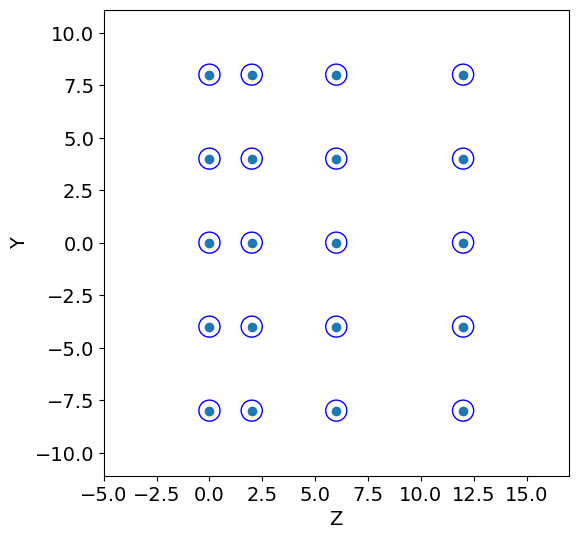

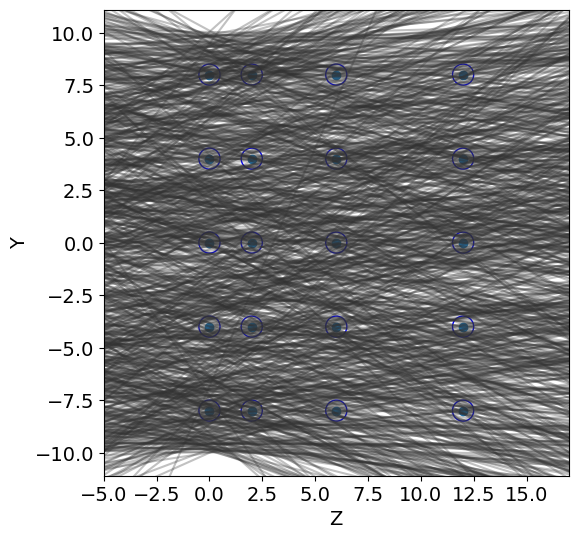

fraction of tracks detected:  0.242
resolution:  0.2498114451369561


In [ ]:
# CONSTANT PARAMETERS
#------ define mother region ------#
y_min=-10.1
y_max=10.1
N_tracks = 1000


print("::::: BASELINE PARAMETERS :::::")
R = .5
pitch = 4.0
y1 = 0.0
y2 = 0.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

print("R, pitch, y1, y2, y3, z1, z2, z3: ", R, pitch, y1, y2, y3, z1, z2, z3,"\n")


#------------- GEOMETRY ---------------#
print(":::: INITIAL GEOMETRY ::::")
tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)

volume = detector2.wires_volume(Y, y_min, y_max,R)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False,pause=5) #5

print("# of wires: ", num_wires, ", volume: ", volume)

#------------- TRACK GENERATION -----------#
print(":::: TRACK GENERATION ::::")
t = detector2.Tracks(b_min=y_min, b_max=y_max, alpha_mean=0, alpha_std=0.3)
tracks = t.generate(N_tracks)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

 #a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
resolution = score[1]
print("fraction of tracks detected: ",frac_detected)
print("resolution: ",resolution)

---

### Define Objectives



Defines a class for the objectives of the problem that can be used in the MOO.  

In [ ]:

class objectives():

  def __init__(self,tracks,y_min,y_max):
    self.tracks = tracks
    self.y_min = y_min
    self.y_max = y_max

  def wrapper_geometry(fun):

      def inner(self):
          R, pitch, y1, y2, y3, z1, z2, z3 = self.X
          self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
          return fun(self)
      return inner

  def update_tracks(self, new_tracks):
    self.tracks = new_tracks

  def update_design_point(self,X):
      self.X = X


  def geometry(self,R, pitch, y1, y2, y3, z1, z2, z3):
    tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
    self.R = R
    self.Z, self.Y = tr.create_geometry()


  @wrapper_geometry
  def calc_score(self):
      res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
      assert res[0] >= 0 and res[1] >= 0,"Fraction or Resolution negative."

      return res


  def get_score(self,X):
    R, pitch, y1, y2, y3, z1, z2, z3 = X
    self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
    res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
    return res


  def get_volume(self):
    volume = detector2.wires_volume(self.Y, self.y_min, self.y_max,self.R)
    return volume



res = objectives(tracks,y_min,y_max)

#res.geometry(R, pitch, y1, y2, y3, z1, z2, z3)

X = R, pitch, y1, y2, y3, z1, z2, z3
#fscore  = res.get_score(X)
res.update_design_point(X)
fscore  = res.calc_score()[0]
fvolume = res.get_volume()

print("...check: ", fvolume, fscore)


...check:  62.800000000000004 0.242


---
### Multi-Objective Optimization

We will be using `ax-platform` (https://ax.dev).  

+ In this  example we will be using Multi-Objective Bayesian Optimization (MOBO) using qNEHVI + [SAASBO](https://proceedings.mlr.press/v161/eriksson21a.html)

+  

+ Notice that every function is minimized. Our efficiency is defined as an tracking inefficiency = 1 - efficiency

+ We add the resolution as a third objective.  The average residual of the track hit from the wire centre is used as a proxy for the resolution for this toy-model




In [ ]:
#---------------------- BOTORCH FUNCTIONS ------------------------#

def build_experiment(search_space,optimization_config):
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

def glob_fun(loc_fun):
    @wraps(loc_fun)
    def inner(xdic):
        x_sorted = [xdic[p_name] for p_name in xdic.keys()] #it assumes x will be given as, e.g., dictionary
        res = list(loc_fun(x_sorted))
        return res

    return inner

def initialize_experiment(experiment,N_INIT):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    experiment.new_batch_trial(sobol.gen(N_INIT)).run()

    return experiment.fetch_data()

@glob_fun
def ftot(xdic):
    return (1- res.get_score(xdic)[0], res.get_volume(), res.get_score(xdic)[1])

def f1(xdic):
    return ftot(xdic)[0] #obj1

def f2(xdic):
    return ftot(xdic)[1] #obj2

#def f3(xdic):
    #return ftot(xdic)[2] #obj3

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    }


# Define Hyper-parameters for the optimization
N_BATCH = 5
Q_SIZE = 1
dim_space = 8 # len(X)
N_INIT = 2 * (dim_space + 1) #
lowerv = np.array([0.5,2.5,0.,0.,0.,2.,2.,2.])
upperv = np.array([1.0,5.0,4.,4.,4.,10.,10.,10.])

In [ ]:

# defining the search space one can also include constraints in this function
search_space = SearchSpace(
    parameters=
    [RangeParameter(name=f"x{i}", lower=lowerv[i], upper=upperv[i],
                    parameter_type=ParameterType.FLOAT) for i in range(dim_space)]
    )
print (search_space)

# define the metrics for optimization
metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=True)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=True)
#metric_c = GenericNoisyFunctionMetric("c", f=f3, noise_sd=0.0, lower_is_better=True)

mo = MultiObjective(objectives=[Objective(metric=metric_a)
                                ,Objective(metric=metric_b)
                                #,Objective(metric=metric_c)
                                ]
                    )

ref_point = [-1.1]*len(mo.metrics)
refpoints = torch.Tensor(ref_point).to(**tkwargs) # [1.1, 1.1, 1.1] for 3 objs

objective_thresholds = [ObjectiveThreshold(metric=metric, bound=val, relative=False, op=ComparisonOp.LEQ)
                        for metric, val in zip(mo.metrics, refpoints) #---> this requires defining a torch.float64 object --- by default is (-)1.1 for DTLZ
                        ]


optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds
    )

SearchSpace(parameters=[RangeParameter(name='x0', parameter_type=FLOAT, range=[0.5, 1.0]), RangeParameter(name='x1', parameter_type=FLOAT, range=[2.5, 5.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.0, 4.0]), RangeParameter(name='x3', parameter_type=FLOAT, range=[0.0, 4.0]), RangeParameter(name='x4', parameter_type=FLOAT, range=[0.0, 4.0]), RangeParameter(name='x5', parameter_type=FLOAT, range=[2.0, 10.0]), RangeParameter(name='x6', parameter_type=FLOAT, range=[2.0, 10.0]), RangeParameter(name='x7', parameter_type=FLOAT, range=[2.0, 10.0])], parameter_constraints=[])


In [ ]:
# Build the experiment which should setup the ax optimization
experiment = build_experiment(search_space,optimization_config)

# Initialize the experiment with N_INIT points and run them
data = initialize_experiment(experiment,N_INIT)

In [ ]:
# look into data
data.df

,arm_name,metric_name,mean,sem,trial_index,n,frac_nonnull
0,0_0,a,0.245000,0.0,0,555,0.245000
1,0_1,a,0.403000,0.0,0,555,0.403000
2,0_2,a,0.289000,0.0,0,555,0.289000
3,0_3,a,0.703000,0.0,0,555,0.703000
4,0_4,a,0.663000,0.0,0,555,0.663000
5,0_5,a,0.553000,0.0,0,555,0.553000
6,0_6,a,0.119000,0.0,0,555,0.119000
7,0_7,a,0.569000,0.0,0,555,0.569000
8,0_8,a,0.368000,0.0,0,555,0.368000
9,0_9,a,0.502000,0.0,0,555,0.502000


In [ ]:
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from ax.models.torch.botorch_modular.surrogate import Surrogate
model = Models.BOTORCH_MODULAR(
    experiment=experiment,
    data=data,
    surrogate=Surrogate(
        botorch_model_class=SaasFullyBayesianSingleTaskGP,
        mll_options={
            "num_samples": 256,  # Increasing this may result in better model fits
            "warmup_steps": 512,  # Increasing this may result in better model fits
        },
    )
)

<ipython-input-10-2da4d11865c5>:6: DeprecationWarning:

botorch_model_class is deprecated and will be removed in a future version. Please specify botorch_model_class via `surrogate_spec.model_configs`.

<ipython-input-10-2da4d11865c5>:6: DeprecationWarning:

mll_options is deprecated and will be removed in a future version. Please specify mll_options via `surrogate_spec.model_configs`.



In [ ]:
# let us try to see some predictions of this model
# randomly generate a point in the search space

from ax.modelbridge.factory import get_uniform
from ax.core.observation import ObservationFeatures

gr = get_uniform(search_space).gen(n=1)

gr.param_df.to_dict(orient="records")[0]

obs_feats = [ObservationFeatures(parameters=p) for p in gr.param_df.to_dict(orient="records")]

model.predict(obs_feats)

({'a': [np.float64(0.461358177007079)], 'b': [np.float64(204.46207416326894)]},
 {'a': {'a': [np.float64(0.001707306095896657)], 'b': [np.float64(0.0)]},
  'b': {'a': [np.float64(0.0)], 'b': [np.float64(426.1605352658325)]}})

### Question

Can you do predictions using the MC methods and see if you can have plot the corresponding objectives with errors?


In [ ]:
hv_list = []
BATCH_SIZE = 3
for i in range(N_BATCH):
    print("\n\n...PROCESSING BATCH n.: {}\n\n".format(i+1))

    model = Models.BOTORCH_MODULAR(
    experiment=experiment,
    data=data,
    surrogate=Surrogate(
        botorch_model_class=SaasFullyBayesianSingleTaskGP,
        mll_options={
            "num_samples": 256,  # Increasing this may result in better model fits
            "warmup_steps": 512,  # Increasing this may result in better model fits
            },
          )
        )

    generator_run = model.gen(BATCH_SIZE)   #ask BATCH_SIZE points
    trial = experiment.new_batch_trial(generator_run=generator_run)
    trial.run()
    data = Data.from_multiple_data([data, trial.fetch_data()])   #https://ax.dev/api/core.html#ax.Data.from_multiple_data

    print("\n\n\n...calculate df via exp_to_df (i.e., global dataframe so far):\n\n")


    metric_names = {index: i for index, i in enumerate(mo.metric_names)}
    N_METRICS = len(metric_names)
    df = exp_to_df(experiment).sort_values(by=["trial_index"])
    outcomes = torch.tensor(df[mo.metric_names].values)
    #outcomes, _ = data_to_outcomes(data, N_INIT, i+1, BATCH_SIZE, N_METRICS, metric_names)
    partitioning = DominatedPartitioning(ref_point=refpoints, Y=outcomes.to(**tkwargs))
    try:
        hv = partitioning.compute_hypervolume().item()
    except:
        hv = 0
        print("Failed to compute hv")
    hv_list.append(hv)
    print(f"Iteration: {i+1}, HV: {hv}")



...PROCESSING BATCH n.: 1




<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

botorch_model_class is deprecated and will be removed in a future version. Please specify botorch_model_class via `surrogate_spec.model_configs`.

<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

mll_options is deprecated and will be removed in a future version. Please specify mll_options via `surrogate_spec.model_configs`.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[WARNING 06-08 17:43:07] ax.modelbridge.base: TorchModelBridge(model=BoTorchModel) was not able to generate 3 unique candidates. Generated arms have the following weights, as there are repeats:
[3.0]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 1, HV: 539.4630111216221


...PROCESSING BATCH n.: 2




<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

botorch_model_class is deprecated and will be removed in a future version. Please specify botorch_model_class via `surrogate_spec.model_configs`.

<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

mll_options is deprecated and will be removed in a future version. Please specify mll_options via `surrogate_spec.model_configs`.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[WARNING 06-08 17:45:21] ax.modelbridge.base: TorchModelBridge(model=BoTorchModel) was not able to generate 3 unique candidates. Generated arms have the following weights, as there are repeats:
[3.0]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 2, HV: 539.9811111216221


...PROCESSING BATCH n.: 3




<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

botorch_model_class is deprecated and will be removed in a future version. Please specify botorch_model_class via `surrogate_spec.model_configs`.

<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

mll_options is deprecated and will be removed in a future version. Please specify mll_options via `surrogate_spec.model_configs`.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[WARNING 06-08 17:47:41] ax.modelbridge.base: TorchModelBridge(model=BoTorchModel) was not able to generate 3 unique candidates. Generated arms have the following weights, as there are repeats:
[3.0]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 3, HV: 539.9811111216221


...PROCESSING BATCH n.: 4




<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

botorch_model_class is deprecated and will be removed in a future version. Please specify botorch_model_class via `surrogate_spec.model_configs`.

<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

mll_options is deprecated and will be removed in a future version. Please specify mll_options via `surrogate_spec.model_configs`.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

[WARNING 06-08 17:50:06] ax.modelbridge.base: TorchModelBridge(model=BoTorchModel) was not able to generate 3 unique candidates. Generated arms have the following weights, as there are repeats:
[2.0, 1.0]





...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 4, HV: 539.9811111216221


...PROCESSING BATCH n.: 5




<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

botorch_model_class is deprecated and will be removed in a future version. Please specify botorch_model_class via `surrogate_spec.model_configs`.

<ipython-input-12-e915225d01f4>:9: DeprecationWarning:

mll_options is deprecated and will be removed in a future version. Please specify mll_options via `surrogate_spec.model_configs`.

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal






...calculate df via exp_to_df (i.e., global dataframe so far):


Iteration: 5, HV: 539.9811111216221


### Analysis of Results

#### Inspecting the Hyper volume statistics

In [ ]:
import plotly.express as px

fig = px.scatter(x = np.arange(N_BATCH) + 1, y = hv_list,
           labels={"x": "N_BATCHES",
                    "y": "Hyper Volume"},
           width = 800, height = 800,
           title = "HyperVolume Improvement", )
fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='marker+line'))
fig.data[0].update(mode = "markers+lines")
fig.show()


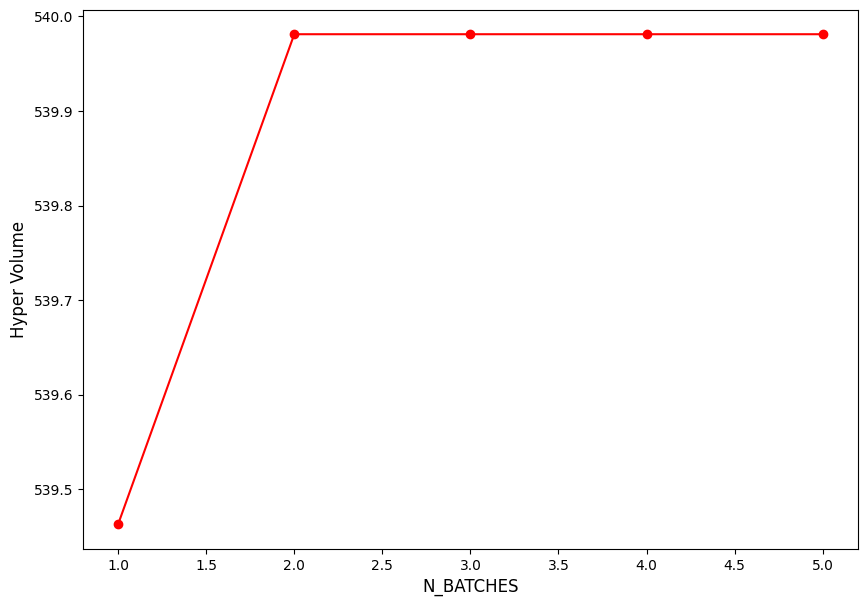

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 7))
plt.plot(np.arange(N_BATCH) + 1 , hv_list, "ro-")
plt.xlabel("N_BATCHES", fontsize = 12)
plt.ylabel("Hyper Volume", fontsize = 12)
plt.show()

### Overall Performance in the Objective space.

In [ ]:
fig1 = px.scatter(df, x="a", y="b", color = "trial_index",
                     labels = { "a": "InEfficiency",
                               "b": "Volume"
                     }, hover_data = df.columns,
                     height = 800, width = 800)
fig1.show()

### Exploration as a function of Iteration number


In [ ]:
obj_fig = px.scatter(df, x="a", y="b", animation_frame="trial_index", color="trial_index",
                        range_x=[0., 0.6], range_y=[0. , 400.],
                     labels = { "a": "InEfficiency",
                               "b": "Volume"}, hover_data = df.columns,
                        width = 800, height = 800)
obj_fig.update(layout_coloraxis_showscale=False)
obj_fig.show()

### Computing posterior pareto frontiers.

Once can sample expected approximate pareto front solution from the built surrogate model.


In [ ]:
from ax.core import metric


# https://ax.dev/api/plot.html#ax.plot.pareto_utils.compute_posterior_pareto_frontier

# absolute_metrics – List of outcome metrics that should NOT be relativized w.r.t. the status quo
# (all other outcomes will be in % relative to status_quo).

# Note that approximated pareto frontier is can be visualized only against 2 objectives.
# So one can try to make mixed plots, to see the ``

n_points_surrogate = 25
frontier = [] #(a,b), (a,c), (b,c)
metric_combos = [(metric_a, metric_b)]

for combo in metric_combos:
    print ("computing pareto frontier : ", combo)
    frontier.append(compute_posterior_pareto_frontier(
        experiment=experiment,
        data=experiment.fetch_data(),
        primary_objective=combo[0], #_b
        secondary_objective=combo[-1], #_a
        absolute_metrics=["a", "b"],
        num_points=n_points_surrogate,
    ))

#render(plot_pareto_frontier(frontier, CI_level=0.9))
#res_front = plot_pareto_frontier(frontier, CI_level=0.8)


computing pareto frontier :  (GenericNoisyFunctionMetric('a'), GenericNoisyFunctionMetric('b'))


In [ ]:
print ("Metric_a, Metric_b")
render(plot_pareto_frontier(frontier[0], CI_level=0.8))

Metric_a, Metric_b


### Validating the computed pareto front performance

Since the model is trained on objectives, One can perform `k-fold` validation to see the performance of the surrgoate model's prediction

In [ ]:
from ax.modelbridge.cross_validation import cross_validate
from ax.plot.diagnostic import tile_cross_validation

#https://ax.dev/api/_modules/ax/modelbridge/cross_validation.html

cv = cross_validate(model, folds = 5)
render(tile_cross_validation(cv))

---

### Exercise 3


- Determine the Pareto set from the 3D front and choose an optimal point

- Plot the optimal configuration of the tracker corresponding to that point

- Do analysis of convergence

- Visualize the point with a radar or petal diagram, following https://pymoo.org/visualization/index.html


